# ENGM 4676 - Machine Learning for Engineers: FINAL PROJECT

## SolarGuard - Predictive Maintenance for Solar Power Systems
**By Jonathan Chartrand and Robert Boutette**

### Purpose
This project leverages machine learning to optimize the maintenance and performance of solar power systems. By developing predictive models, we aim to monitor inverter performance, detect deviations, and anticipate maintenance needs. The ultimate goal is to improve system reliability and efficiency through actionable insights.

### Dataset
We utilized the **Solar Power Generation Data** from Kaggle:  
[**Solar Power Generation Data**](https://www.kaggle.com/datasets/anikannal/solar-power-generation-data)  
This dataset includes:
- Sensor and power generation data collected over 34 days from two solar power plants in India.
- **Inverter-Level Data**: Captures DC power generation for multiple inverters, each tied to arrays of solar panels.
- **Plant-Level Sensor Data**: Provides environmental conditions such as ambient temperature, module temperature, and solar irradiation.

### Approach
Our methodology includes:
1. **Data Preparation**: Cleaning, merging, and scaling inverter and sensor data.
2. **Model Development**: Training Bidirectional LSTM models for time-series predictions of DC power output.
3. **Simulation**: Generating "live" data streams with deviations to simulate real-world faults and degradation.
4. **Web Integration**: Creating a web-based monitoring tool for visualizing performance and identifying maintenance needs.

This project demonstrates the application of machine learning to real-world engineering challenges, delivering a robust solution for solar power management.


In [ ]:
# Import the required libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.optimizers import Adam
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Bidirectional
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os

## Filtering Each Inverter Separately

To analyze the performance of individual inverters, we created a separate DataFrame for each one. The process involved:
1. **Data Loading**: Merging `Generation_Data` and `Weather_Sensor_Data` for Plant 1 on `DATE_TIME`.
2. **Data Cleaning**:
   - Removed unnecessary columns (`PLANT_ID`, `DAILY_YIELD`, `TOTAL_YIELD`).
   - Dropped rows with missing values to ensure clean data.
3. **Dictionary Creation**: 
   - Each unique `SOURCE_KEY` (representing an inverter) was filtered into its own DataFrame.
   - These DataFrames were stored in a dictionary for easy access during model training.

This separation allows us to train individual models tailored to each inverter's unique characteristics and performance data.


In [7]:
# Load the data sets for both plants
generation_data1 = pd.read_csv("data/Plant_1_Generation_Data.csv")
weather_data1 = pd.read_csv("data/Plant_1_Weather_Sensor_Data.csv")

# Ensure DATE_TIME in all datasets is in the same format
generation_data1['DATE_TIME'] = pd.to_datetime(generation_data1['DATE_TIME'], format='%d-%m-%Y %H:%M', errors='coerce')
weather_data1['DATE_TIME'] = pd.to_datetime(weather_data1['DATE_TIME'], format='%Y-%m-%d %H:%M:%S', errors='coerce')

# Specify the columns to merge from the weather data
weather_columns = ['DATE_TIME', 'AMBIENT_TEMPERATURE', 'MODULE_TEMPERATURE', 'IRRADIATION']

# Merge the generation and weather data for both plants
df1 = pd.merge(generation_data1, weather_data1[weather_columns], on='DATE_TIME', how='left')

# Drop the unnecessary columns
df1.drop(columns=['PLANT_ID', 'DAILY_YIELD', 'TOTAL_YIELD'], inplace=True)

# Drop rows with missing values
df1.dropna(inplace=True)

# Create separate dictionaries for each plant
source_key_frames_plant1 = {}

# Process Plant 1
for source_key in df1['SOURCE_KEY'].unique():
    source_key_frames_plant1[f'Plant1_{source_key}'] = df1[df1['SOURCE_KEY'] == source_key]

## Recall our previous Shallow DNN

We used the cleaned and merged data (`df1`) to define the features (`X`) and target (`y`) for training the Shallow DNN:
- **Features**: 
  - `AMBIENT_TEMPERATURE`
  - `MODULE_TEMPERATURE`
  - `IRRADIATION`
- **Target**: 
  - `DC_POWER`

This setup provides a simple baseline for predicting power output across all inverters before transitioning to more sophisticated, inverter-specific models like the Bidirectional LSTM.


C:\Users\jonni\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


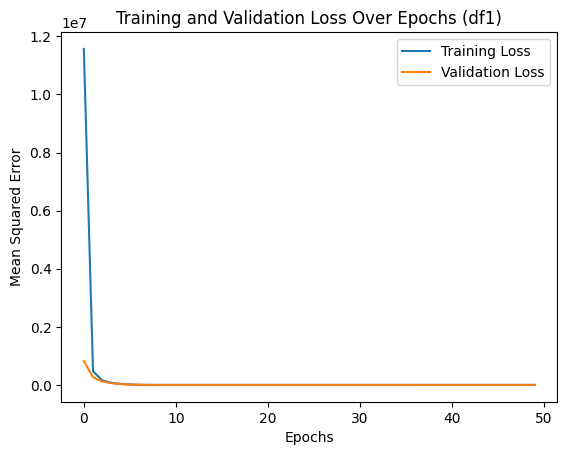

430/430 ━━━━━━━━━━━━━━━━━━━━ 0s 310us/step
Shape of y_pred: (13755, 1)
Shape of y_test: (13755,)


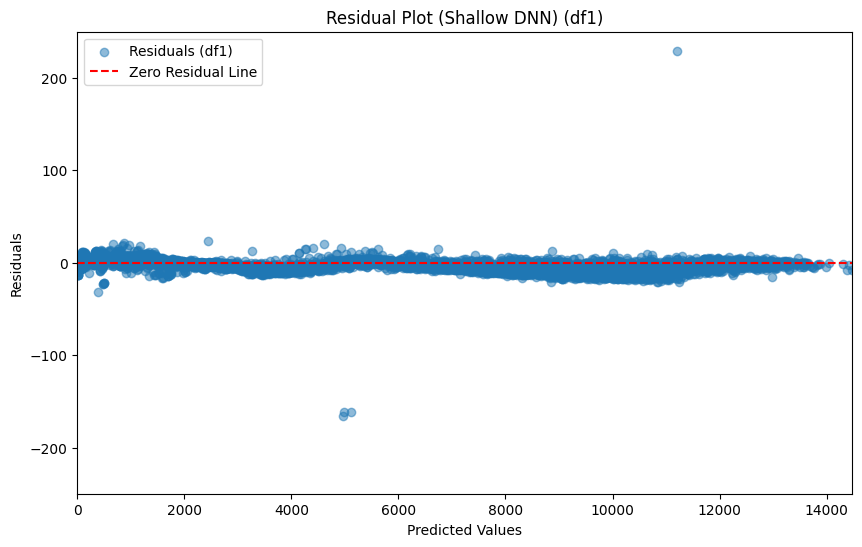

Test Loss: 152.97840881347656
Mean Absolute Error: 3.4597349166870117
R^2 Score (Shallow DNN): 0.9999905334000018


In [8]:
# Define features and target
X = df1[['AMBIENT_TEMPERATURE', 'MODULE_TEMPERATURE', 'IRRADIATION', 'AC_POWER']]
y = df1['DC_POWER']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Standardize the features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Build the shallow DNN model
model = Sequential()
model.add(Dense(32, input_dim=X_train.shape[1], activation='relu'))
model.add(Dense(16, activation='relu'))
model.add(Dense(1))

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mae'])

# Train the model
history = model.fit(X_train, y_train, epochs=50, batch_size=32, validation_split=0.2, verbose=0)

# Plot training and validation loss
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Mean Squared Error')
plt.title('Training and Validation Loss Over Epochs (df1)')
plt.legend()
plt.show()

# Predict
y_pred = model.predict(X_test)
print(f"Shape of y_pred: {y_pred.shape}")
print(f"Shape of y_test: {y_test.shape}")

# Ensure indices are aligned
y_test = y_test.reset_index(drop=True)

# Calculate residuals
residuals_shallow = y_test - y_pred.flatten()

# Define consistent axis ranges
x_range = [0, max(y_pred.flatten().max(), 1400)]  # Max prediction + buffer
y_range = [-250, 250]  # Adjust based on residual range

# Plot residuals
plt.figure(figsize=(10, 6))
plt.scatter(y_pred.flatten(), residuals_shallow, alpha=0.5, label='Residuals (df1)')
plt.axhline(y=0, color='r', linestyle='--', label='Zero Residual Line')
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')
plt.title('Residual Plot (Shallow DNN) (df1)')
plt.xlim(x_range)
plt.ylim(y_range)
plt.legend()
plt.show()

# Evaluate the model
loss, mae = model.evaluate(X_test, y_test, verbose=0)
print(f'Test Loss: {loss}')
print(f'Mean Absolute Error: {mae}')

# Calculate R^2
shallow_r2 = r2_score(y_test, y_pred)
print(f'R^2 Score (Shallow DNN): {shallow_r2}')


The results were fantastic, however we have some issues with their usability for this project:

- The data spans across multiple inverters, which are tied to an unknown amount (and perhaps disproportionate amount) of panels.
- No information is provided regarding the model of the panels, inverters, supplementary equipment, etc.
- We have no way of knowing if these inverters/panels were installed at once or their current state of degredation

For this reason, we opted to instead perform an analysis on each individual inverter - this way we have a model for the current state of each inverter (and the panels tied to it) and can deduce future maintainence needs on it's current baseline. 
## Analysis of Shallow DNN Results

The Shallow DNN delivered excellent results for DC power prediction but had critical limitations for this project:
1. **Data Aggregation**: Spanning multiple inverters with no clarity on how many panels are tied to each, making individual performance analysis impossible.
2. **Missing Equipment Details**: No information on panel, inverter models, or supplementary hardware.
3. **Unknown Installation History**: Lacking degradation or installation timelines, limiting baseline accuracy.

## Why Focus on Individual Inverters?

To address these gaps, we opted for an individual inverter analysis:
- **Tailored Models**: Captures each inverter’s unique state for precise baseline tracking.
- **Actionable Insights**: Predicts performance deviations, enabling targeted maintenance.
- **Baseline Comparisons**: Tracks degradation trends for future optimization.

## Why LSTM Models?

Bi-directional LSTM models were selected for their ability to process time-series data:
1. **Temporal Dependencies**: Ideal for predicting DC power, influenced by environmental factors and historical performance.
2. **Bi-Directional Learning**: Utilizes both past and future contexts for higher accuracy.
3. **Scalability**: Easily trainable on individual datasets, allowing efficient deployment.

## Conclusion

By moving from a Shallow DNN to bi-directional LSTM models for individual inverters, SolarGuard achieves:
- Accurate, per-inverter predictions.
- Real-time maintenance tracking.
- Enhanced system reliability through actionable insights.

Running Bidirectional LSTM model for Inverter 1...


Model for Panel 1 saved to saved_models\inverter1_lstm_model.h5



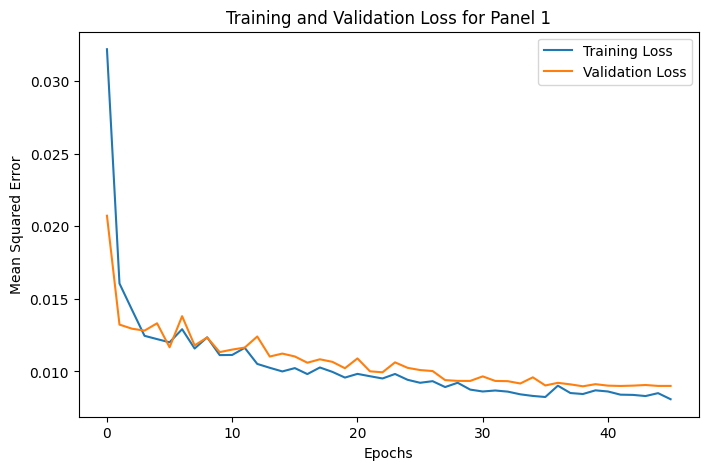

20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step


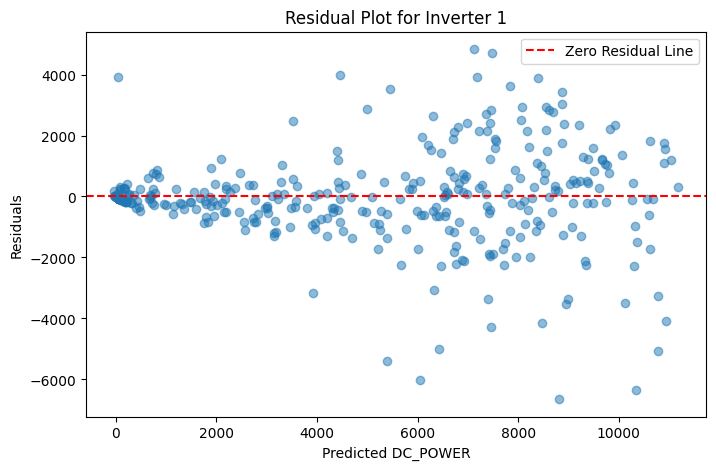

Inverter 1 - Test Loss: 0.0076, MAE: 0.0439, R^2: 0.9044

Running Bidirectional LSTM model for Inverter 2...


Model for Panel 2 saved to saved_models\inverter2_lstm_model.h5



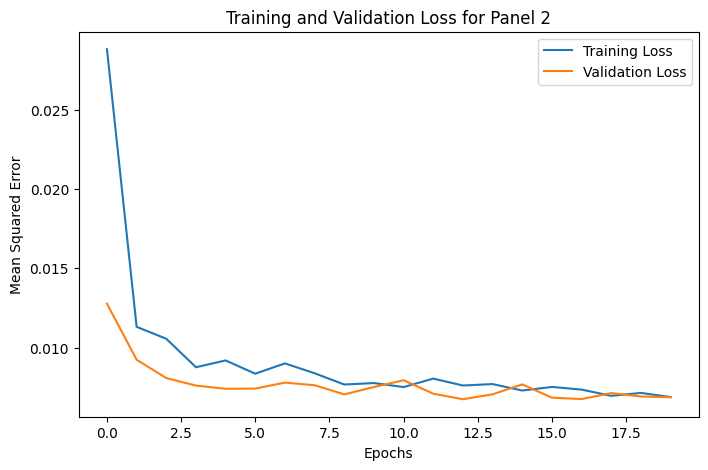

20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step


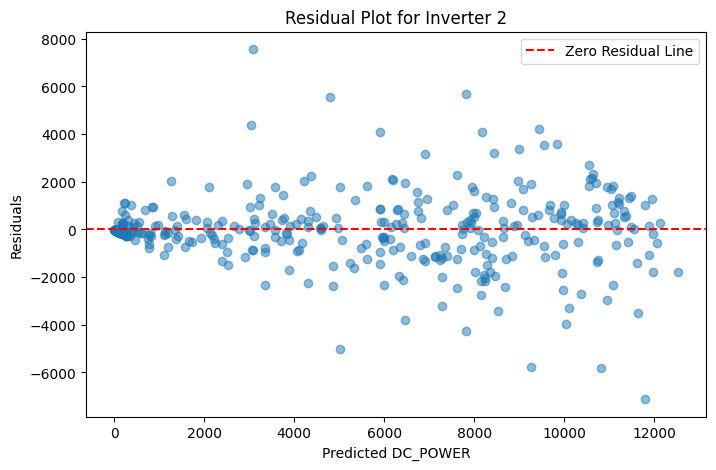

Inverter 2 - Test Loss: 0.0066, MAE: 0.0421, R^2: 0.9204

Running Bidirectional LSTM model for Inverter 3...


Model for Panel 3 saved to saved_models\inverter3_lstm_model.h5



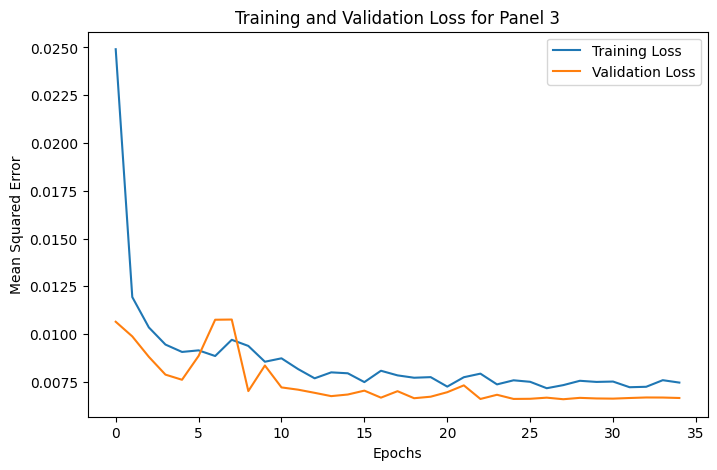

20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step


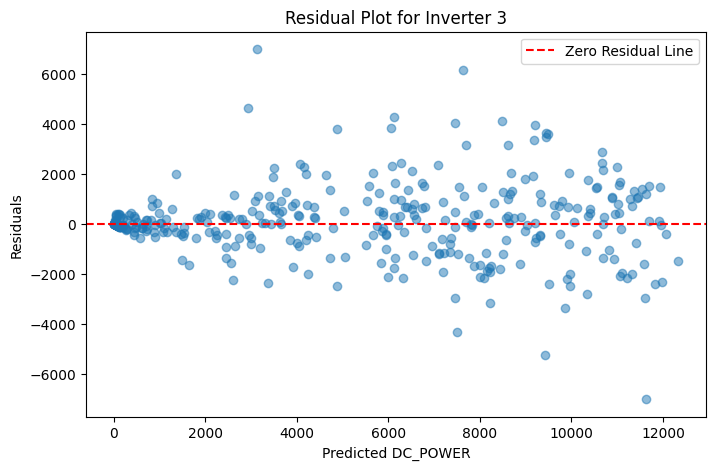

Inverter 3 - Test Loss: 0.0061, MAE: 0.0403, R^2: 0.9258

Running Bidirectional LSTM model for Inverter 4...


Model for Panel 4 saved to saved_models\inverter4_lstm_model.h5



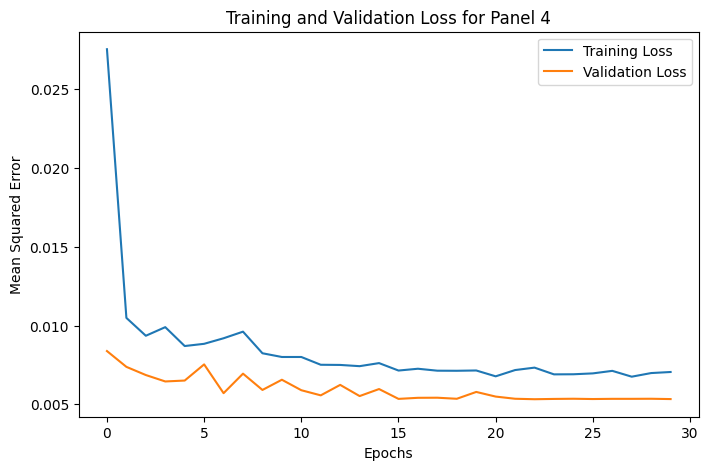

20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step


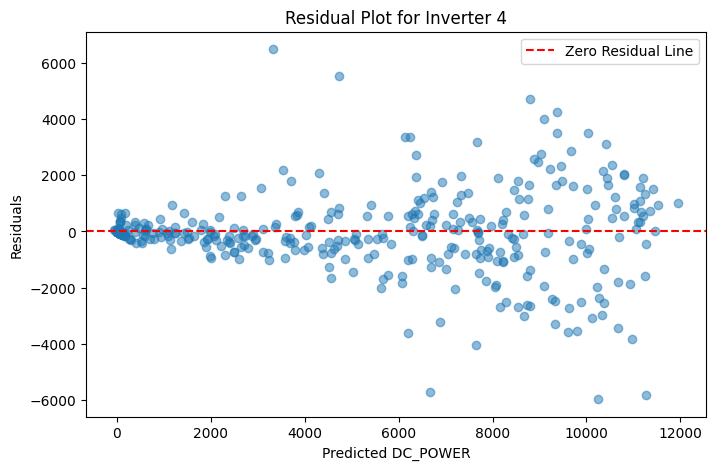

Inverter 4 - Test Loss: 0.0062, MAE: 0.0398, R^2: 0.9209

Running Bidirectional LSTM model for Inverter 5...


Model for Panel 5 saved to saved_models\inverter5_lstm_model.h5



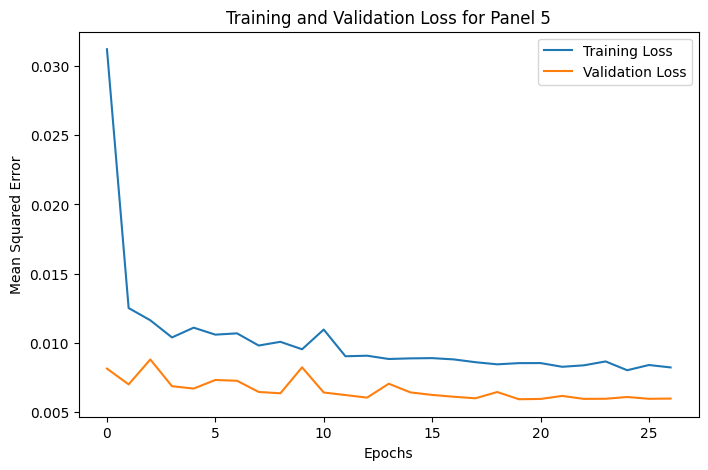

20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step


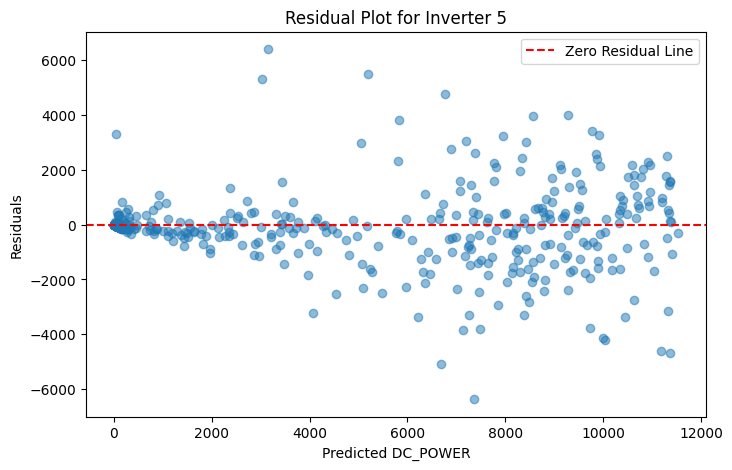

Inverter 5 - Test Loss: 0.0068, MAE: 0.0431, R^2: 0.9184

Running Bidirectional LSTM model for Inverter 6...


Model for Panel 6 saved to saved_models\inverter6_lstm_model.h5



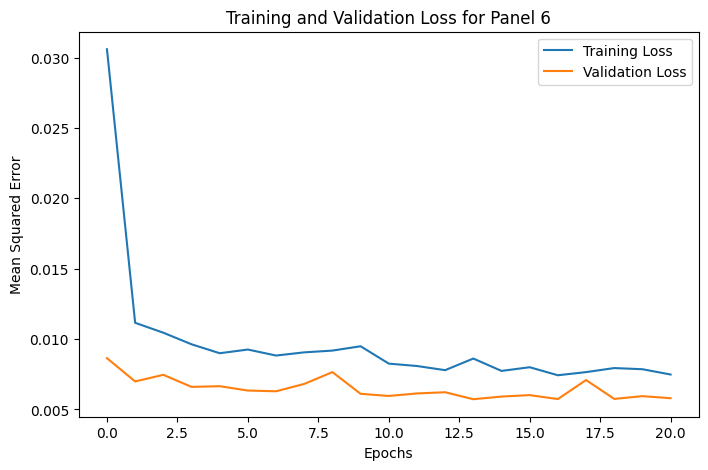

20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step


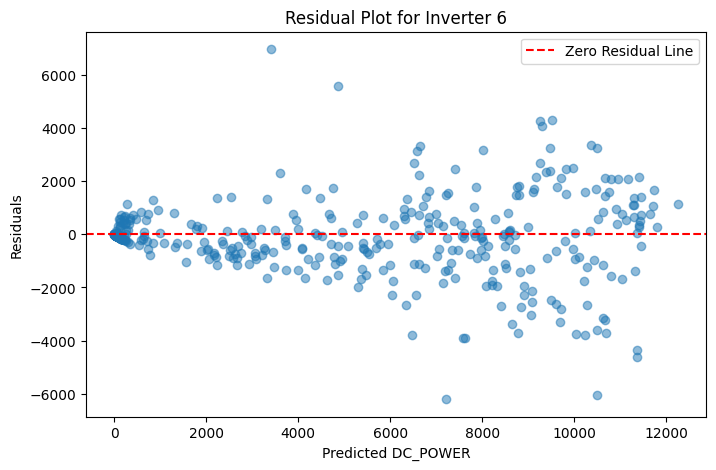

Inverter 6 - Test Loss: 0.0068, MAE: 0.0451, R^2: 0.9162

Running Bidirectional LSTM model for Inverter 7...


Model for Panel 7 saved to saved_models\inverter7_lstm_model.h5



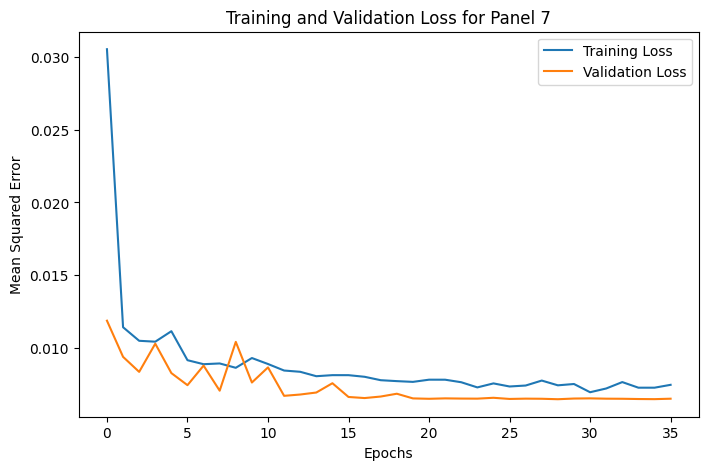

20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step


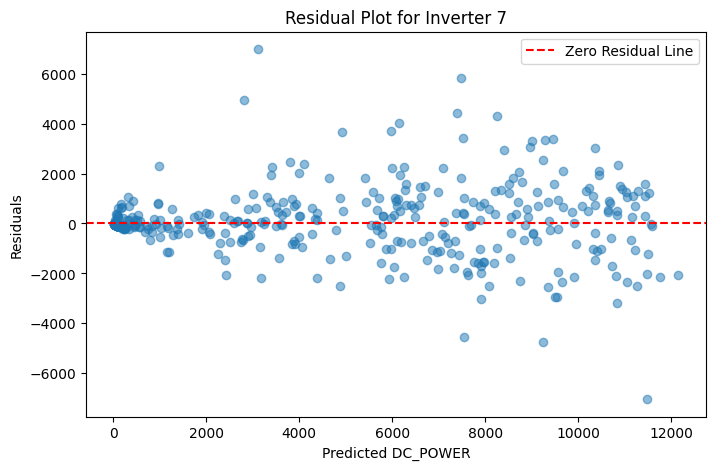

Inverter 7 - Test Loss: 0.0061, MAE: 0.0418, R^2: 0.9251

Running Bidirectional LSTM model for Inverter 8...


Model for Panel 8 saved to saved_models\inverter8_lstm_model.h5



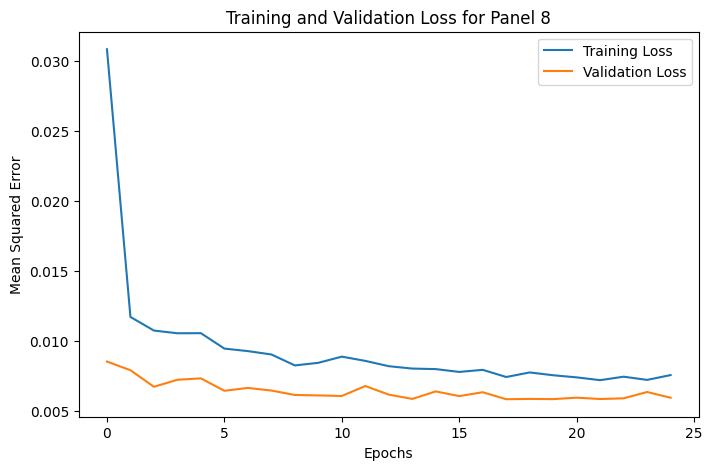

20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step


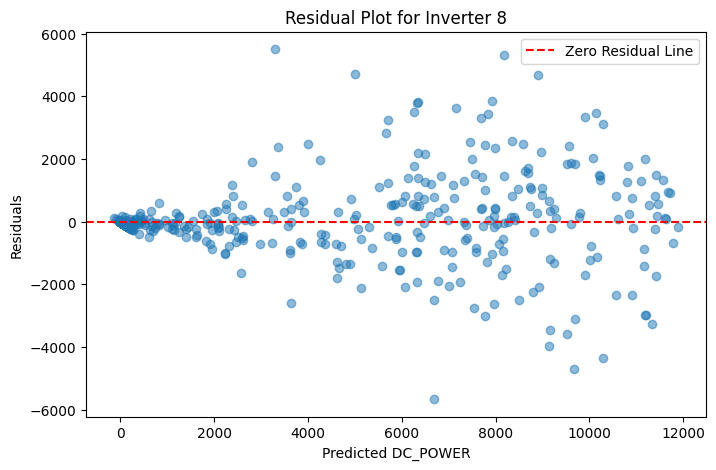

Inverter 8 - Test Loss: 0.0057, MAE: 0.0397, R^2: 0.9263

Running Bidirectional LSTM model for Inverter 9...


Model for Panel 9 saved to saved_models\inverter9_lstm_model.h5



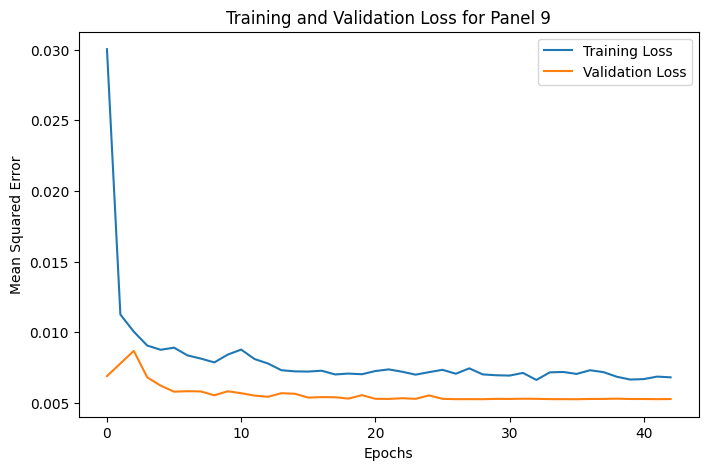

20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step


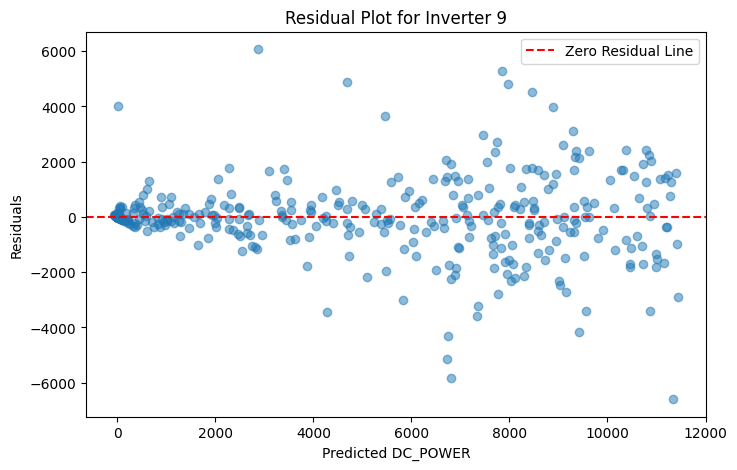

Inverter 9 - Test Loss: 0.0059, MAE: 0.0379, R^2: 0.9216

Running Bidirectional LSTM model for Inverter 10...


Model for Panel 10 saved to saved_models\inverter10_lstm_model.h5



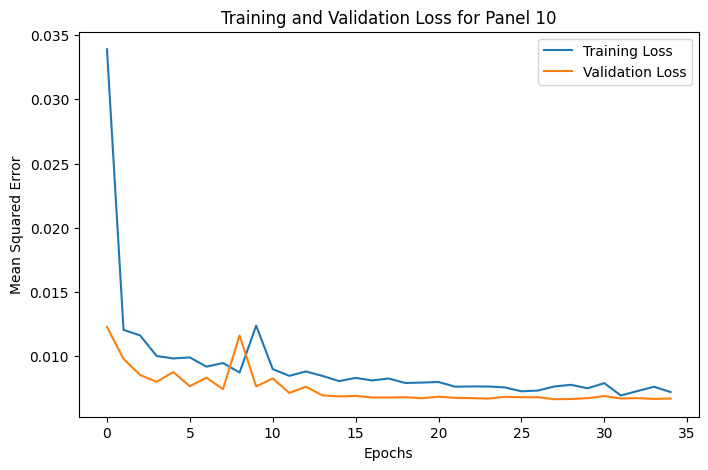

20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step


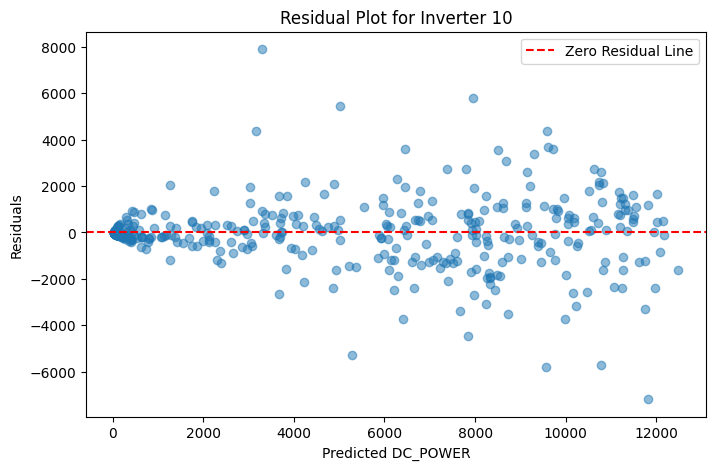

Inverter 10 - Test Loss: 0.0066, MAE: 0.0423, R^2: 0.9206

Running Bidirectional LSTM model for Inverter 11...


Model for Panel 11 saved to saved_models\inverter11_lstm_model.h5



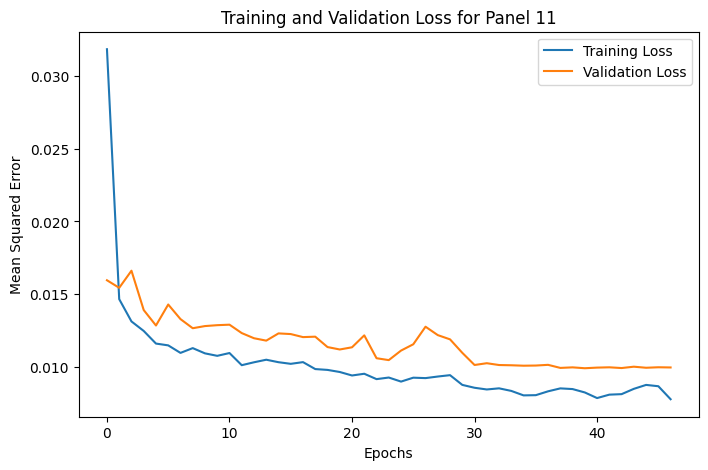

20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step


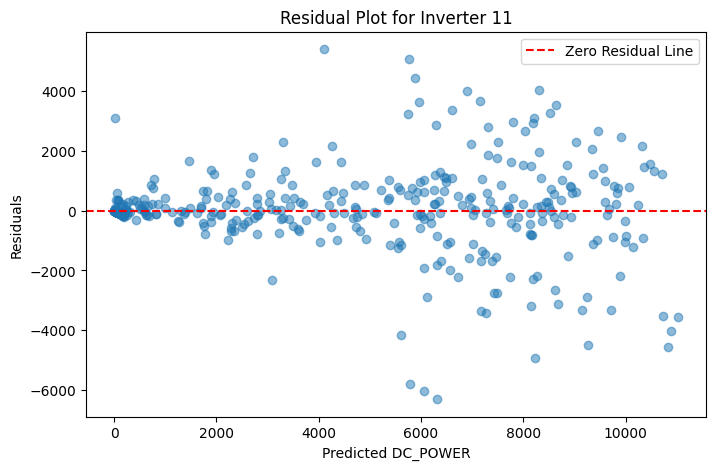

Inverter 11 - Test Loss: 0.0076, MAE: 0.0420, R^2: 0.9017

Running Bidirectional LSTM model for Inverter 12...


Model for Panel 12 saved to saved_models\inverter12_lstm_model.h5



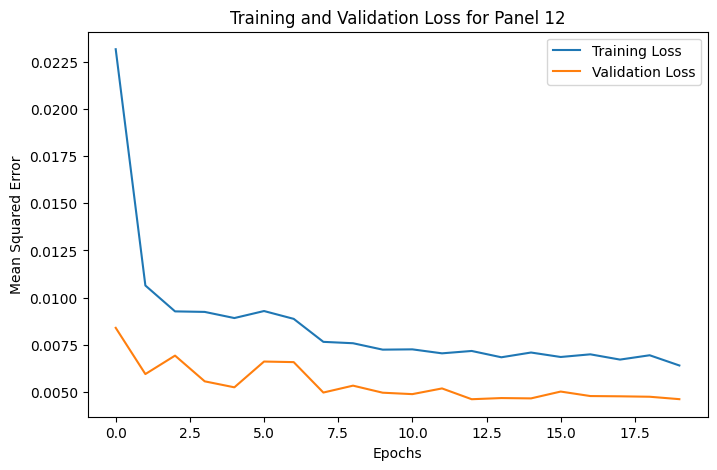

20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step


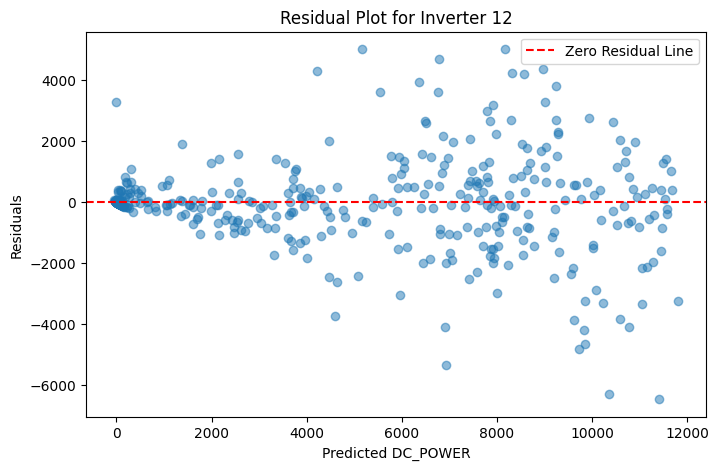

Inverter 12 - Test Loss: 0.0070, MAE: 0.0430, R^2: 0.9075

Running Bidirectional LSTM model for Inverter 13...


Model for Panel 13 saved to saved_models\inverter13_lstm_model.h5



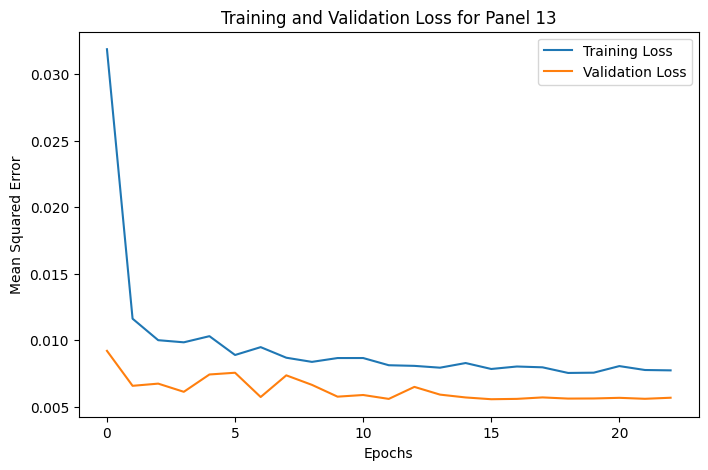

20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step


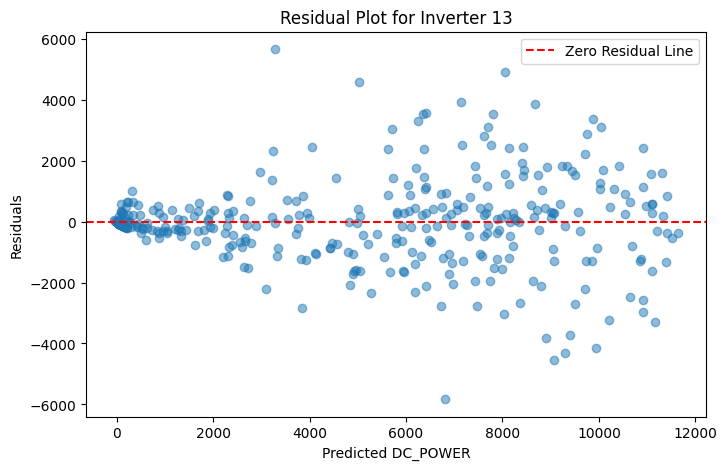

Inverter 13 - Test Loss: 0.0058, MAE: 0.0399, R^2: 0.9232

Running Bidirectional LSTM model for Inverter 14...


Model for Panel 14 saved to saved_models\inverter14_lstm_model.h5



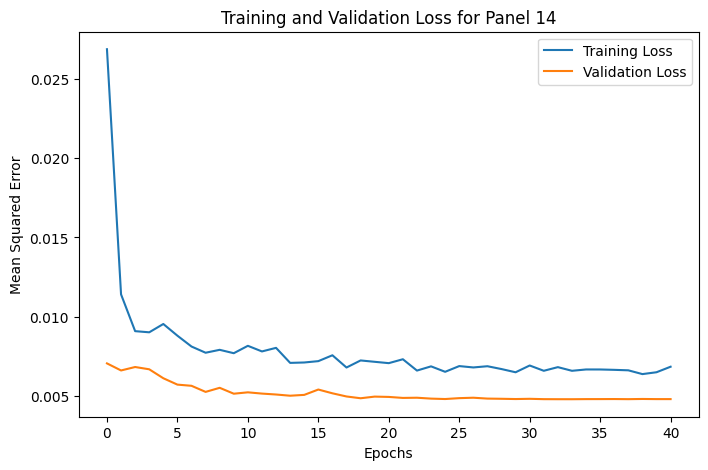

20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step


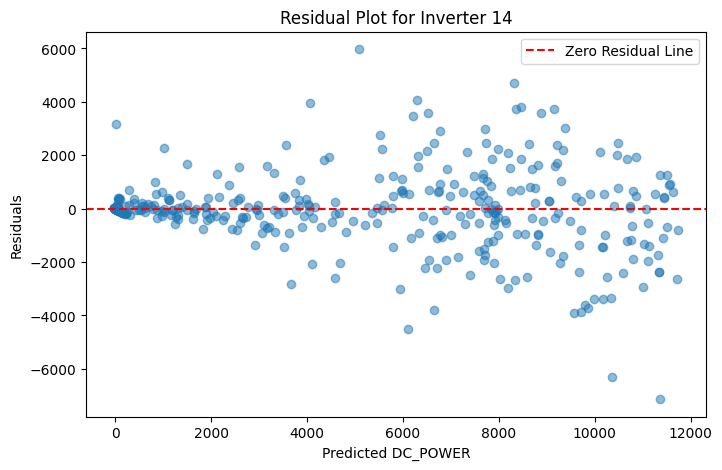

Inverter 14 - Test Loss: 0.0066, MAE: 0.0411, R^2: 0.9146

Running Bidirectional LSTM model for Inverter 15...


Model for Panel 15 saved to saved_models\inverter15_lstm_model.h5



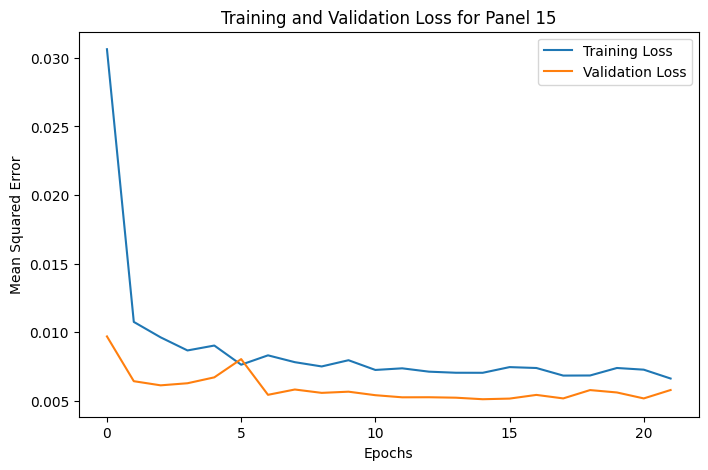

20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step


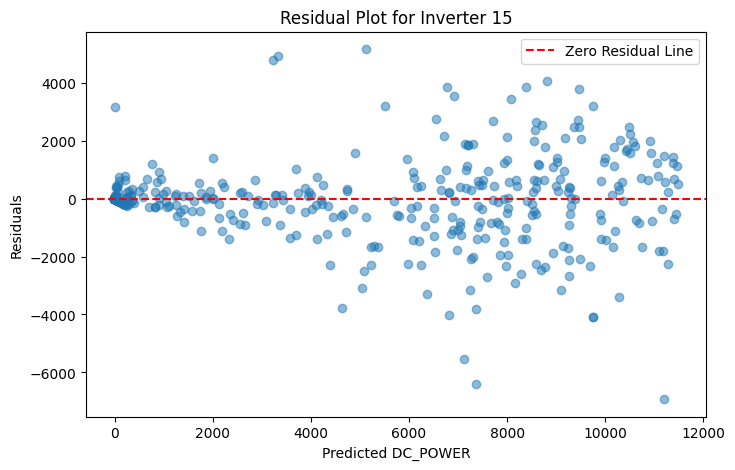

Inverter 15 - Test Loss: 0.0067, MAE: 0.0426, R^2: 0.9183

Running Bidirectional LSTM model for Inverter 16...


Model for Panel 16 saved to saved_models\inverter16_lstm_model.h5



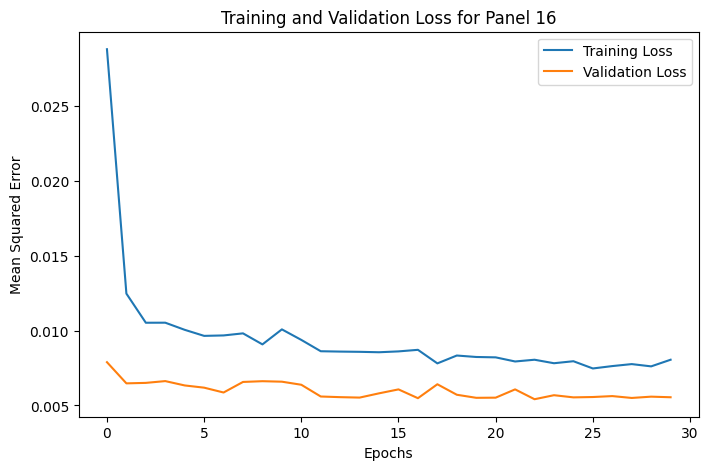

20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step


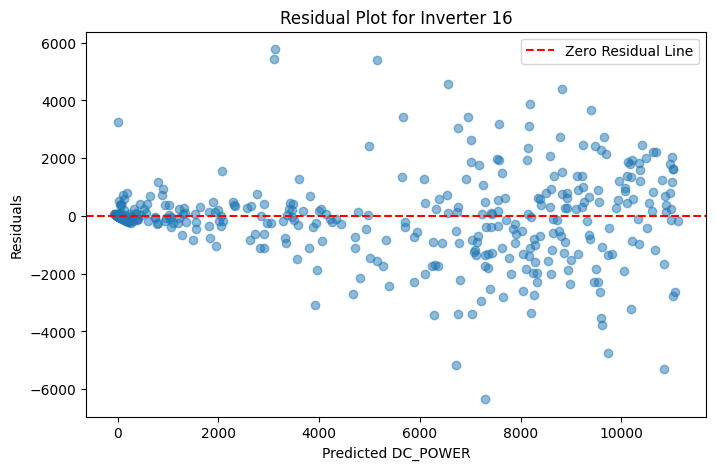

Inverter 16 - Test Loss: 0.0067, MAE: 0.0428, R^2: 0.9163

Running Bidirectional LSTM model for Inverter 17...


Model for Panel 17 saved to saved_models\inverter17_lstm_model.h5



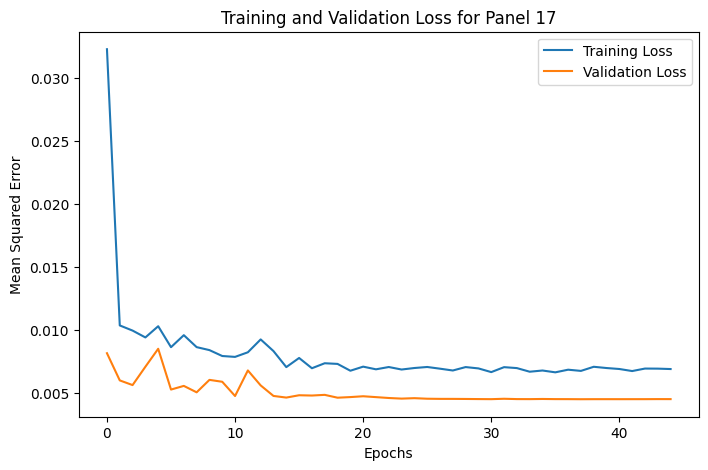

20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step


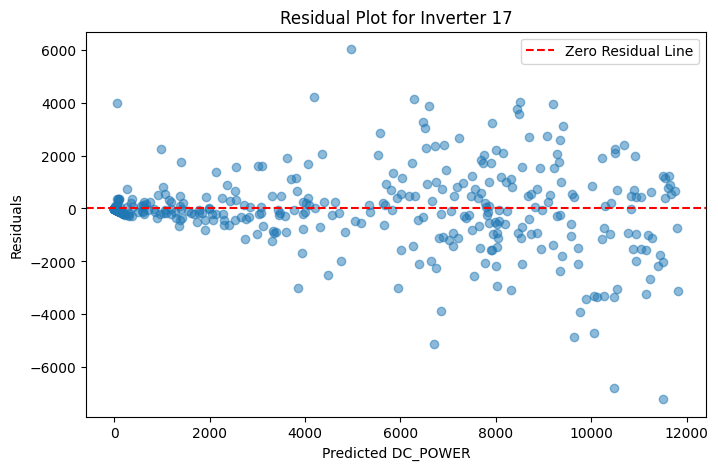

Inverter 17 - Test Loss: 0.0070, MAE: 0.0429, R^2: 0.9106

Running Bidirectional LSTM model for Inverter 18...


Model for Panel 18 saved to saved_models\inverter18_lstm_model.h5



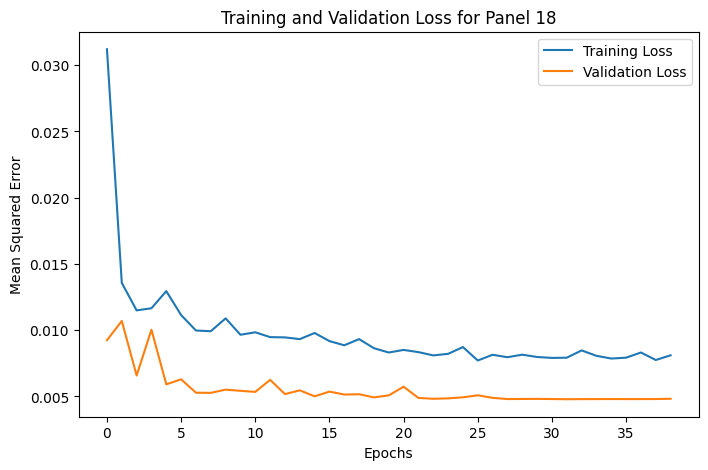

20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step


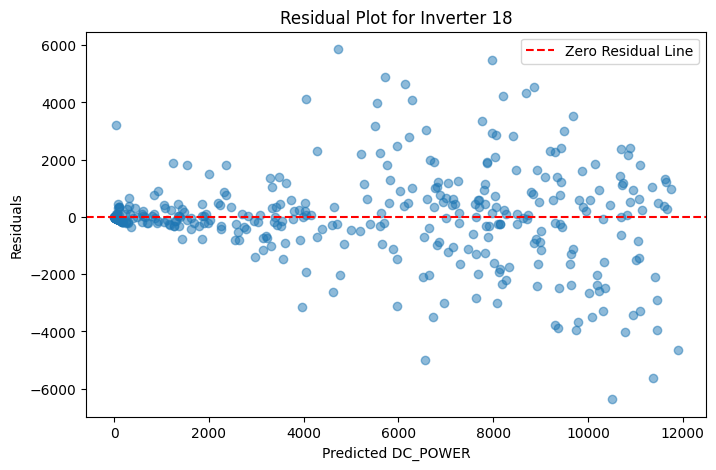

Inverter 18 - Test Loss: 0.0073, MAE: 0.0435, R^2: 0.9044

Running Bidirectional LSTM model for Inverter 19...


Model for Panel 19 saved to saved_models\inverter19_lstm_model.h5



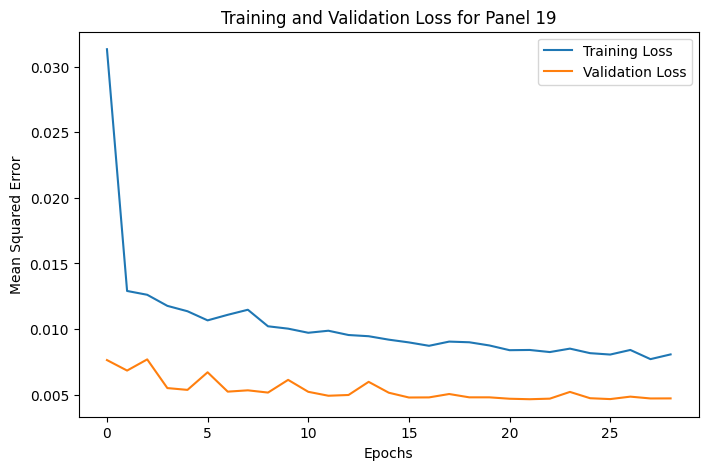

20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step


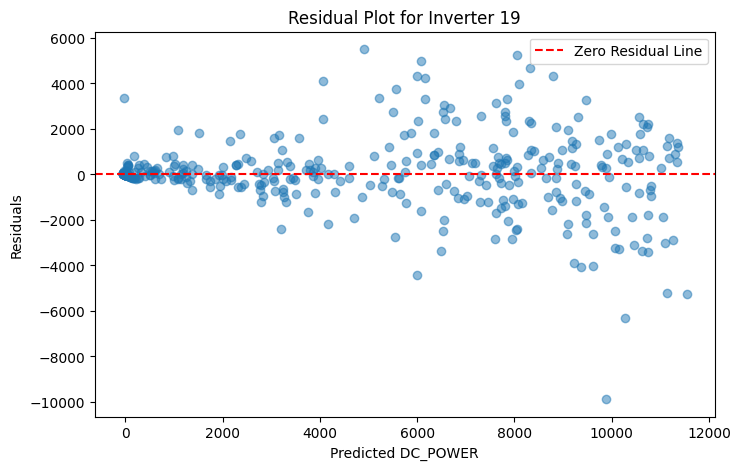

Inverter 19 - Test Loss: 0.0079, MAE: 0.0441, R^2: 0.8962

Running Bidirectional LSTM model for Inverter 20...


Model for Panel 20 saved to saved_models\inverter20_lstm_model.h5



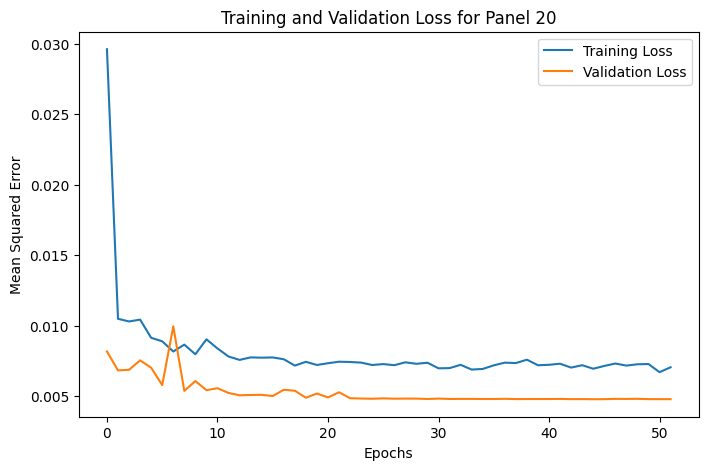

20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step


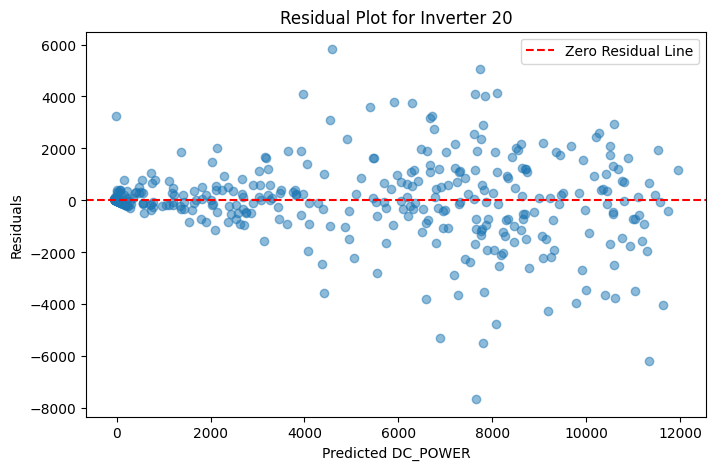

Inverter 20 - Test Loss: 0.0073, MAE: 0.0436, R^2: 0.9022

Running Bidirectional LSTM model for Inverter 21...


Model for Panel 21 saved to saved_models\inverter21_lstm_model.h5



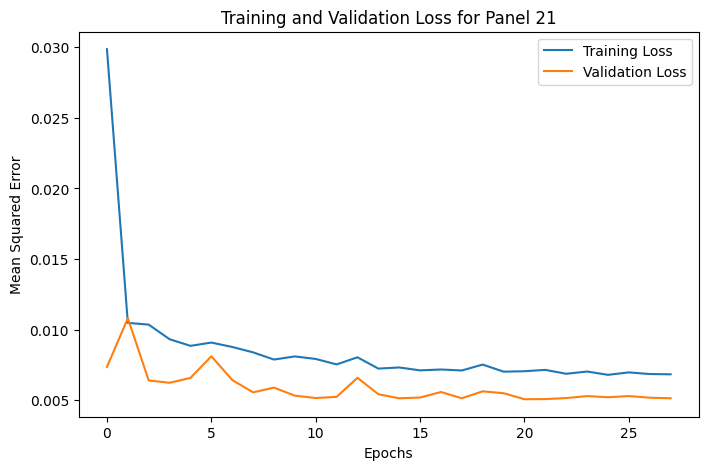

20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step


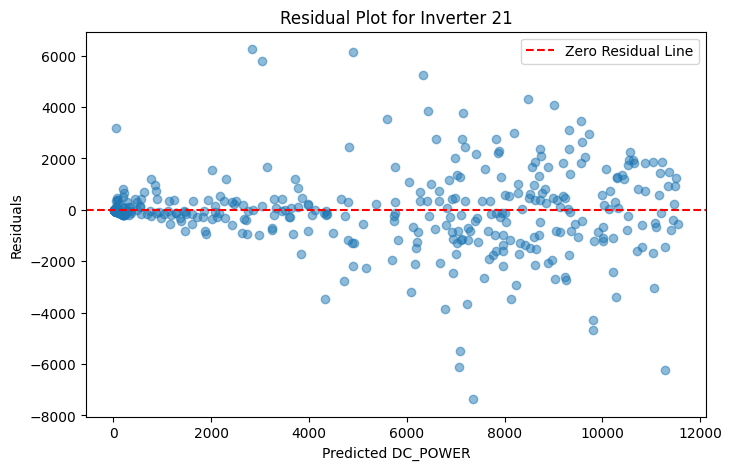

Inverter 21 - Test Loss: 0.0073, MAE: 0.0434, R^2: 0.9103

Running Bidirectional LSTM model for Inverter 22...


Model for Panel 22 saved to saved_models\inverter22_lstm_model.h5



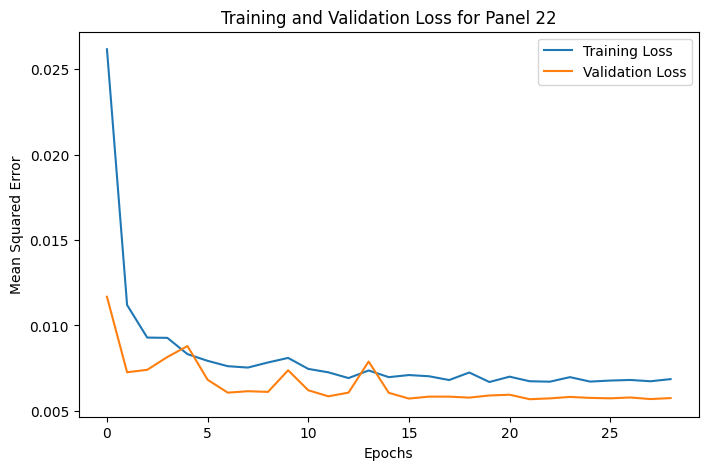

20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step


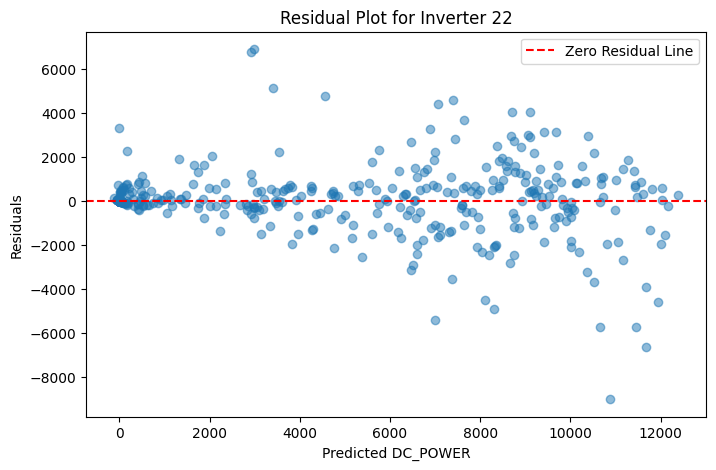

Inverter 22 - Test Loss: 0.0078, MAE: 0.0432, R^2: 0.9016

             Test Loss  Mean Absolute Error  R^2 Score
Inverter 1    0.007601             0.043864   0.904368
Inverter 2    0.006589             0.042127   0.920440
Inverter 3    0.006120             0.040288   0.925822
Inverter 4    0.006163             0.039849   0.920948
Inverter 5    0.006776             0.043120   0.918363
Inverter 6    0.006784             0.045097   0.916204
Inverter 7    0.006091             0.041758   0.925091
Inverter 8    0.005749             0.039656   0.926343
Inverter 9    0.005858             0.037878   0.921570
Inverter 10   0.006619             0.042343   0.920585
Inverter 11   0.007649             0.041963   0.901722
Inverter 12   0.007019             0.043049   0.907498
Inverter 13   0.005755             0.039941   0.923246
Inverter 14   0.006582             0.041134   0.914553
Inverter 15   0.006674             0.042575   0.918300
Inverter 16   0.006679             0.042788   0.916312
Invert

In [9]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Bidirectional
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os

# Directory to save models
MODEL_DIR = "saved_models"
os.makedirs(MODEL_DIR, exist_ok=True)  # Create the directory if it doesn't exist

# Set sequence length
SEQUENCE_LENGTH = 15  # Increased sequence length for capturing longer temporal patterns

def create_sequences(data, target, sequence_length):
    """
    Create sequences for LSTM input.
    """
    sequences = []
    labels = []
    for i in range(len(data) - sequence_length):
        seq = data[i:i + sequence_length]
        label = target[i + sequence_length]
        sequences.append(seq)
        labels.append(label)
    return np.array(sequences), np.array(labels)

# Initialize scalers
scaler_X = MinMaxScaler()
scaler_y = MinMaxScaler()

# Store results
results = {}

# Iterate through Plant 1 DataFrames
for panel_number, (panel_key, df) in enumerate(source_key_frames_plant1.items(), start=1):
    print(f"Running Bidirectional LSTM model for Inverter {panel_number}...")

    # Ensure data is sorted by time
    df = df.sort_values('DATE_TIME')

    # Define features and target
    X = df[['AMBIENT_TEMPERATURE', 'MODULE_TEMPERATURE', 'IRRADIATION']].values
    y = df['DC_POWER'].values.reshape(-1, 1)

    # Scale features and target
    X_scaled = scaler_X.fit_transform(X)
    y_scaled = scaler_y.fit_transform(y).flatten()

    # Create sequences for LSTM
    X_sequences, y_sequences = create_sequences(X_scaled, y_scaled, SEQUENCE_LENGTH)

    # Split the data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(X_sequences, y_sequences, test_size=0.2, random_state=42)

    # Build the Bidirectional LSTM model
    model = Sequential([
        Bidirectional(LSTM(128, activation='relu', return_sequences=True)),  # Increased units
        Dropout(0.3),
        Bidirectional(LSTM(64, activation='relu')),
        Dropout(0.3),
        Dense(1)  # Output layer for a single target: DC_POWER
    ])

    # Compile the model with a reduced learning rate
    model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mae'])

    # Use EarlyStopping and ReduceLROnPlateau
    early_stopping = EarlyStopping(monitor='val_loss', patience=7, restore_best_weights=True)
    reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-5)

    # Train the model
    history = model.fit(
        X_train, y_train,
        epochs=100,
        batch_size=32,
        validation_split=0.2,
        verbose=0,
        callbacks=[early_stopping, reduce_lr]
    )
    
    # Save the model
    model_path = os.path.join(MODEL_DIR, f"inverter{panel_number}_lstm_model.h5")
    model.save(model_path)
    print(f"Model for Panel {panel_number} saved to {model_path}\n")
    
    # Plot training and validation loss
    plt.figure(figsize=(8, 5))
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Mean Squared Error')
    plt.title(f'Training and Validation Loss for Panel {panel_number}')
    plt.legend()
    plt.show()

    # Predict and calculate residuals
    y_pred = model.predict(X_test)
    y_pred_original = scaler_y.inverse_transform(y_pred.reshape(-1, 1)).flatten()
    y_test_original = scaler_y.inverse_transform(y_test.reshape(-1, 1)).flatten()
    residuals = y_test_original - y_pred_original

    # Plot residuals
    plt.figure(figsize=(8, 5))
    plt.scatter(y_pred_original, residuals, alpha=0.5)
    plt.axhline(y=0, color='r', linestyle='--', label="Zero Residual Line")
    plt.xlabel('Predicted DC_POWER')
    plt.ylabel('Residuals')
    plt.title(f'Residual Plot for Inverter {panel_number}')
    plt.legend()
    plt.show()

    # Evaluate the model
    loss, mae = model.evaluate(X_test, y_test, verbose=0)
    r2 = r2_score(y_test_original, y_pred_original)

    # Store results for this panel
    results[f"Inverter {panel_number}"] = {
        'Test Loss': loss,
        'Mean Absolute Error': mae,
        'R^2 Score': r2
    }

    # Print results for the current panel
    print(f"Inverter {panel_number} - Test Loss: {loss:.4f}, MAE: {mae:.4f}, R^2: {r2:.4f}\n")

# Compile results into a summary DataFrame
results_df = pd.DataFrame(results).T
print(results_df)

# Save the results to a CSV
results_df.to_csv('bidirectional_lstm_results_per_panel_dc_power.csv')


## Bidirectional LSTM Results for Individual Inverters

### Approach
We trained **Bidirectional LSTM models** for each inverter using the following key steps:
1. **Data Preparation**:
   - Input features: `AMBIENT_TEMPERATURE`, `MODULE_TEMPERATURE`, `IRRADIATION`.
   - Target: `DC_POWER`.
   - Data was scaled using `MinMaxScaler` and sequences of length 15 were created.
2. **Model Architecture**:
   - Bi-directional LSTM layers with `128` and `64` units, interspersed with 30% dropout.
   - A dense layer to output the final `DC_POWER` prediction.
3. **Optimization**:
   - Optimizer: Adam.
   - Loss: Mean Squared Error (MSE).
   - EarlyStopping and ReduceLROnPlateau for efficient training.
4. **Evaluation**:
   - Metrics: Test Loss (MSE), Mean Absolute Error (MAE), and R² Score.
   - Separate models for each inverter ensured specific baselines for degradation tracking.

### Results
The Bidirectional LSTM models demonstrated strong performance:
- **Test Loss**: Ranges from `0.0055` to `0.0078`, indicating low prediction errors.
- **MAE**: Between `0.038` and `0.045`, suggesting high accuracy.
- **R² Scores**: Predominantly above `0.90`, reflecting excellent fit across inverters.

### Conclusion
By focusing on individual inverters with Bidirectional LSTM models, we achieved:
- Accurate, per-inverter performance baselines.
- Tailored predictions to track degradation over time.
- Actionable insights to optimize maintenance and minimize downtime.
This approach establishes a robust framework for predictive maintenance and performance monitoring in solar systems.


## Simulating Live Data for Web Application

To demonstrate the practical use of our Bidirectional LSTM models in a web application, we created a simulated stream of live data. This process involved the following steps:

### 1. Generating Predicted DC Output Values
- **Input**: We started with a CSV file containing environmental data (`ambient_temp`, `module_temp`, `irradiation`) within the ranges of our original dataset.
- **Prediction**:
  - Each environmental data row was passed through the trained LSTM models for all 22 inverters.
  - The models predicted the `DC_POWER` for each inverter, which was scaled back to its original range and stored in the `measured_dc` columns of a new CSV file.

### 2. Modifying Predicted Values for Simulation
To simulate real-world variations and potential faults:
- **Deviations**:
  - A small percentage of rows were modified to deviate from the predicted values by:
    - **5-10% deviation** for "warnings."
    - **>11% deviation** for "faults" (applied to specific rows/columns).
  - Other values were slightly adjusted by ±4.5% to mimic natural variation.
- **Rotating Column Logic**:
  - One inverter was randomly selected per row for the >11% deviation, ensuring a fair distribution of faults across inverters.
  - The >11% deviation was applied to three consecutive rows for each selected inverter column.

### 3. Analyzing Deviation Trends
- The deviations were used to calculate a running average of the percentage difference for each inverter.
- This average helps identify the current state of degradation in the inverter or its connected array structure.

### 4. Output
- The modified data was saved as `live_sim_data.csv`, simulating live sensor data with realistic environmental and operational variations.
- The live data stream enables the web application to visualize inverter performance, highlight warnings or faults, and provide actionable insights for maintenance.

This simulated data framework provides a robust demonstration of the potential for integrating predictive models into real-world solar system monitoring applications.


In [12]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import load_model
import os

# Define paths based on your folder structure
csv_path = os.path.join('Data', 'sensor_data.csv')  # Path to your CSV file
output_csv_path = os.path.join('Data', 'updated_simulated_sensor_data.csv')  # Path for the updated CSV file
models_dir = os.path.join('saved_models')  # Directory where your .h5 models are stored

# Recreate scalers based on expected feature and target ranges
scaler_X = MinMaxScaler().fit([[20.4, 18.14, 0.0], [35.25, 65.55, 1.22]])
scaler_y = MinMaxScaler().fit([[0], [14471.13]])

# Load models
models = {f'inverter{i}': load_model(os.path.join(models_dir, f'inverter{i}_lstm_model.h5')) for i in range(1, 23)}

# Load the CSV file
data = pd.read_csv(csv_path)

# Ensure measured_dc columns exist in the DataFrame
for i in range(1, 23):
    if f'measured_dc{i}' not in data.columns:
        data[f'measured_dc{i}'] = np.nan

# Update the "measured_dc" values with predictions
for index, row in data.iterrows():
    # Prepare input features
    ambient_temp = row['ambient_temp']
    module_temp = row['module_temp']
    irradiation = row['irradiation']

    # Scale features
    weather_features = np.array([[ambient_temp, module_temp, irradiation]])
    weather_features_scaled = scaler_X.transform(weather_features)

    for i in range(1, 23):  # Loop through each panel
        model = models[f'inverter{i}']
        
        try:
            # Prepare input for LSTM model
            input_sequence = np.array([weather_features_scaled] * 15).reshape(1, 15, -1)
            
            # Predict DC value
            predicted_scaled = model.predict(input_sequence)
            predicted_dc = scaler_y.inverse_transform(predicted_scaled)[0][0]
        except Exception as e:
            print(f"Prediction error for Inverter {i}: {e}")
            predicted_dc = np.nan  # Set to NaN if prediction fails
        
        # Update the measured_dc column
        data.at[index, f'measured_dc{i}'] = round(predicted_dc, 3) if not np.isnan(predicted_dc) else "Error"

# Save the updated CSV
data.to_csv(output_csv_path, index=False)
print(f"Simulated sensor data saved to {output_csv_path}")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 222ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 229ms/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 239ms/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 235ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 244ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 243ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 245ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 240ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 218ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 217ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 221ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 219ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 221ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 221ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 218ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 227ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 234ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 243ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 243ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 215ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 219ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 253ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17m

In [13]:
import pandas as pd
import random
import os

# Define paths for input and output CSV files
input_csv_path = os.path.join('Data', 'updated_simulated_sensor_data.csv')  # Correct path to the input CSV file
output_csv_path = os.path.join('Data', 'live_sim_data.csv')  # Output file path

# Load the CSV file
data = pd.read_csv(input_csv_path)

# Identify columns with "measured_dc" in their names
measured_dc_columns = [col for col in data.columns if 'measured_dc' in col]

# Initialize a variable to track which column should have >11% deviation
rotating_column_index = 0

# Apply deviations to each row
for index, row in data.iterrows():
    # Randomly choose one column for the 5-10% deviation, excluding the rotating column
    rotating_column = measured_dc_columns[rotating_column_index]
    available_columns = [col for col in measured_dc_columns if col != rotating_column]
    special_column = random.choice(available_columns)

    for column in measured_dc_columns:
        if column == special_column:
            # Apply 5-10% deviation for the chosen column
            data.at[index, column] = row[column] * random.uniform(1.05, 1.10)
        elif column == rotating_column:
            # Apply >11% deviation for 3 consecutive rows
            if index % 3 == 0 or index % 3 == 1 or index % 3 == 2:
                data.at[index, column] = row[column] * random.uniform(1.11, 1.15)
            else:
                # Apply ±4.5% deviation for this column when not in the 3 consecutive rows
                data.at[index, column] = row[column] * random.uniform(0.955, 1.045)
        else:
            # Apply ±4.5% deviation for all other columns
            data.at[index, column] = row[column] * random.uniform(0.955, 1.045)

    # Rotate the column index every 3 rows
    if (index + 1) % 3 == 0:
        rotating_column_index = (rotating_column_index + 1) % len(measured_dc_columns)

# Save the updated DataFrame to a new CSV file
data.to_csv(output_csv_path, index=False)

print(f"Modified data saved to {output_csv_path}")


Modified data saved to Data\live_sim_data.csv


## Visualizing the Bidirectional LSTM Model

To enhance our web application and provide clear documentation of the Bidirectional LSTM model architecture, we generated a graphical representation of the model structure. This diagram highlights the flow of data through the layers and serves as a visual aid for understanding the model's complexity.

### Process
1. **Model Architecture**:
   - Input: A sequence of length 15 with 3 features (`AMBIENT_TEMPERATURE`, `MODULE_TEMPERATURE`, `IRRADIATION`).
   - Layers:
     - **Bidirectional LSTM**:
       - First layer with 128 units and `relu` activation.
       - Second layer with 64 units and `relu` activation.
     - **Dropout Layers**: Added with a 30% dropout rate to reduce overfitting.
     - **Dense Layer**: Outputs the predicted `DC_POWER`.

2. **Visualization**:
   - Used `plot_model` from `tensorflow.keras.utils` to create a detailed diagram.
   - Saved the diagram as an image (`lstm_model_diagram.png`) in the `model_plots` directory.

### Output
The resulting graphic provides a clear representation of the model's layers, including:
- Input and output shapes for each layer.
- Layer types (Bidirectional LSTM, Dropout, Dense).
- Data flow through the model.

This visualization was integrated into the web application to communicate the model architecture to users and stakeholders effectively.

**Model diagram saved to**: `model_plots/lstm_model_diagram.png`


In [15]:
from tensorflow.keras.utils import plot_model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Bidirectional, Input
import os

# Directory to save the model plot
PLOT_DIR = "model_plots"
os.makedirs(PLOT_DIR, exist_ok=True)

# Build the Bidirectional LSTM model (updated to use Input layer)
SEQUENCE_LENGTH = 15  # As per your model
NUM_FEATURES = 3      # Number of input features (AMBIENT_TEMPERATURE, MODULE_TEMPERATURE, IRRADIATION)

model = Sequential([
    Input(shape=(SEQUENCE_LENGTH, NUM_FEATURES)),  # Use Input layer to define the input shape
    Bidirectional(LSTM(128, activation='relu', return_sequences=True)),
    Dropout(0.3),
    Bidirectional(LSTM(64, activation='relu')),
    Dropout(0.3),
    Dense(1)
])

# Save the model diagram as an image
plot_path = os.path.join(PLOT_DIR, "lstm_model_diagram.png")
plot_model(model, to_file=plot_path, show_shapes=True, show_layer_names=True)

print(f"Model diagram saved to {plot_path}")


Model diagram saved to model_plots\lstm_model_diagram.png
